# **Lecture ResNet Model**

In this module we will implement the architecture of ResNet. ResNet Model like VGG also has multiple configurations. Each configuration specifies the number of layers and the size of each layer. 

This model was introduced in 2015 and is given in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

<br>

The basic idea behind the ResNet network is the `Residual Connection`.

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. There is an example of an identity residual connection given below:

<img src ="https://drive.google.com/uc?export=view&id=1qhL6RwBzujtOMM-t1oMFfK4T8IxLgsnk" width = 500 >

<br>

The different ResNet configurations are given as:

<img src ="https://drive.google.com/uc?export=view&id=19fMY19sKoiLmdSh2-vnAdRJoKn4fUeFj" width = 500 >

<br>

**We will not implement any of the above deep networrks. We will just show how the residual blocks can be implemented in PyTorch.**

# <Font color = 'pickle'>**ResNet with identity blocks**
<img src ="https://drive.google.com/uc?export=view&id=1OIjA4aLDI8q_ENAuuRQroGa0nli7CXBl" width = 500 >
<br><br>
<img src ="https://drive.google.com/uc?export=view&id=1HGXAcIifqNAkhhIbFkbvaa5CT5xxXoPw" width = 500 >

Picture taklen from : https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb

# Setup environment

In [20]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


In [21]:
custom_function_folder = base_folder/'data/custom-functions/fall_2023'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-17'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/imagenette2'
kaggle_api_folder = base_folder/'data/.kaggle'

In [22]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

2023-10-23 04:12:36.549739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /home/harpreet/mambaforge/lib/python3.10/site-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [24]:
nn.Conv2d??

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

# Adaptive Pooling

In [25]:
import torch.nn as nn
import torch
m = nn.AdaptiveAvgPool2d((5,5))
input = torch.randn(1, 64, 10, 10)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 5])


# Global Pooling

In [26]:
m = nn.AdaptiveAvgPool2d((1,1))
input = torch.randn(1, 64, 10, 10)
output = m(input)
print(output.shape)

torch.Size([1, 64, 1, 1])


# Model

In [27]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = x
        out = self.main_path(x)
        residual = self.downsample(residual)
        out += residual
        out = nn.ReLU(inplace=True)(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=120):
        super(SimpleResNet, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),  # Output: 16x250x188
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # Output: 16x125x94
            ResidualBlock(16, 32, stride=2),                       # Output: 32x63x47
            ResidualBlock(32, 64, stride=2),                       # Output: 64x32x24
            ResidualBlock(64, 128, stride=2),                      # Output: 128x16x12
            ResidualBlock(128, 256, stride=2),                     # Output: 256x8x6
            nn.AdaptiveAvgPool2d((1, 1))                           # Output: 256x1x1
        )
        
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [28]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=10)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 1256120
Trainable parameters: 1256120


# Function to load the model

In [29]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(model_config['num_classes'])
    return model


# Functions for Transformations

In [30]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [31]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# Function to load LightningModule

In [32]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [33]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

# Function to load components

In [34]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [35]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [36]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

# Function to free memory

In [37]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [38]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.3 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.024     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.78, Val_Metric: 0.00 | 

`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 4.80, Train_Metric: 0.00


# Find Learning Rate

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 4.79, Val_Metric: 0.00 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.
Learning rate set to 0.004641588833612778
Restoring states from the checkpoint path at /home/harpreet/Insync/google_drive_teaching/teaching_fall_2023/DL/8a_CNN_Training/.lr_find_7c20f9a5-bac8-41a4-94f3-307752ed7d98.ckpt
Restored all states from the checkpoint at /home/harpreet/Insync/google_drive_teaching/teaching_fall_2023/DL/8a_CNN_Training/.lr_find_7c20f9a5-bac8-41a4-94f3-307752ed7d98.ckpt


Train_Loss: 3.58, Train_Metric: 0.17
0.004641588833612778


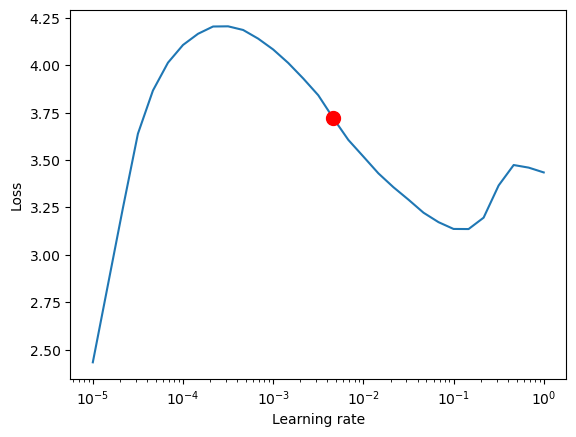

In [39]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [40]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.005
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 1.3 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.79, Val_Metric: 0.00 | 

/home/harpreet/mambaforge/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.77, Val_Metric: 0.10 | Train_Loss: 4.86, Train_Metric: 0.00


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 4.76, Val_Metric: 0.10 | Train_Loss: 3.22, Train_Metric: 1.00


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 4.67, Val_Metric: 0.10 | 

`Trainer.fit` stopped: `max_epochs=3` reached.


Train_Loss: 1.09, Train_Metric: 1.00


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

Global seed set to 42
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/home/harpreet/mambaforge/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2023/dog_breed/oct-17/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNe

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 4.78, Val_Metric: 0.00 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.08, Val_Metric: 0.24 | 

Metric val_loss improved. New best score: 2.078


Train_Loss: 2.10, Train_Metric: 0.30


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.92, Val_Metric: 0.41 | 

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 1.918


Train_Loss: 1.65, Train_Metric: 0.44


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.69, Val_Metric: 0.42 | 

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 1.693


Train_Loss: 1.50, Train_Metric: 0.49


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.50, Val_Metric: 0.50 | 

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 1.497


Train_Loss: 1.33, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.92, Val_Metric: 0.45 | Train_Loss: 1.20, Train_Metric: 0.60
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.35, Val_Metric: 0.58 | 

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 1.352


Train_Loss: 1.03, Train_Metric: 0.67


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 1.39, Val_Metric: 0.56 | Train_Loss: 0.94, Train_Metric: 0.70
Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 1.39, Val_Metric: 0.58 | Train_Loss: 0.81, Train_Metric: 0.74
Epoch 00008: reducing learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.91, Val_Metric: 0.70 | 

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 0.915


Train_Loss: 0.72, Train_Metric: 0.77


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.90, Val_Metric: 0.70 | 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.904


Train_Loss: 0.65, Train_Metric: 0.79


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.93, Val_Metric: 0.69 | Train_Loss: 0.63, Train_Metric: 0.80
Epoch 00011: reducing learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.86, Val_Metric: 0.74 | 

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.858


Train_Loss: 0.58, Train_Metric: 0.82


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.83, Val_Metric: 0.74 | 

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.830


Train_Loss: 0.55, Train_Metric: 0.83


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.84, Val_Metric: 0.73 | Train_Loss: 0.52, Train_Metric: 0.84
Epoch 00014: reducing learning rate of group 0 to 1.5625e-04.


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 0.80, Val_Metric: 0.75 | 

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.801


Train_Loss: 0.49, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 0.80, Val_Metric: 0.74 | Train_Loss: 0.48, Train_Metric: 0.86
Epoch 00016: reducing learning rate of group 0 to 7.8125e-05.


Validation: 0it [00:00, ?it/s]

Epoch 17: Val_Loss: 0.79, Val_Metric: 0.75 | 

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.793


Train_Loss: 0.46, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 18: Val_Loss: 0.80, Val_Metric: 0.74 | Train_Loss: 0.45, Train_Metric: 0.87
Epoch 00018: reducing learning rate of group 0 to 3.9063e-05.


Validation: 0it [00:00, ?it/s]

Epoch 19: Val_Loss: 0.79, Val_Metric: 0.75 | 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.786


Train_Loss: 0.44, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 20: Val_Loss: 0.79, Val_Metric: 0.75 | Train_Loss: 0.44, Train_Metric: 0.87
Epoch 00020: reducing learning rate of group 0 to 1.9531e-05.


Validation: 0it [00:00, ?it/s]

Epoch 21: Val_Loss: 0.79, Val_Metric: 0.75 | Train_Loss: 0.44, Train_Metric: 0.88
Epoch 00021: reducing learning rate of group 0 to 9.7656e-06.


Validation: 0it [00:00, ?it/s]

Epoch 22: Val_Loss: 0.79, Val_Metric: 0.75 | Train_Loss: 0.43, Train_Metric: 0.88
Epoch 00022: reducing learning rate of group 0 to 4.8828e-06.


Validation: 0it [00:00, ?it/s]

Epoch 23: Val_Loss: 0.79, Val_Metric: 0.75 | Train_Loss: 0.43, Train_Metric: 0.88
Epoch 00023: reducing learning rate of group 0 to 2.4414e-06.


Validation: 0it [00:00, ?it/s]

Epoch 24: Val_Loss: 0.79, Val_Metric: 0.75 | 

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.786. Signaling Trainer to stop.


Train_Loss: 0.44, Train_Metric: 0.87
Epoch 00024: reducing learning rate of group 0 to 1.2207e-06.


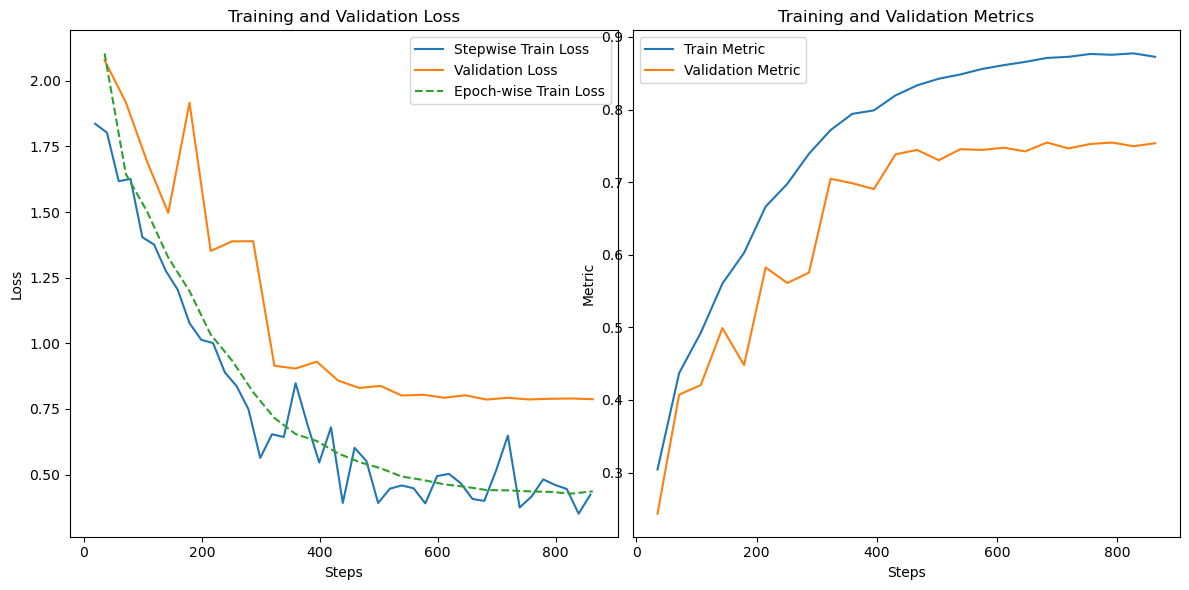

Restoring states from the checkpoint path at /home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684.ckpt
/home/harpreet/mambaforge/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 25: Val_Loss: 0.41, Val_Metric: 0.88 | 

Restoring states from the checkpoint path at /home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/harpreet/Insync/google_drive_shaannoor/data/models/dl_fall_2023/dog_breed/oct-17/logs/epoch=18-step=684.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 25: Val_Loss: 0.79, Val_Metric: 0.75 | Train Accuracy: 88.43
Validation Accuracy: 75.46


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-AdamW,█████▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▇▇▆▆▅▅▄▄▄▃▃▂▂▂▃▃▂▂▁▂▂▁▁▁▁▂▂▁▁▁▂▂▁▁▂▁▁▁
train_metric,▁▃▃▄▅▅▆▆▇▇▇▇▇███████████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▇▆▆▇▅▅▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▃
val_metric,▁▃▃▄▃▅▄▅▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇█▇
epoch,24
lr-AdamW,0.0
train_loss_epoch,0.43595


In [41]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=50
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.005
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'min', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_CNN'
cl_config['wandb']['name']='simple_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=128
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()